### Recommendation System using Deep Learning

In this notebook we are going to learn how to create a model that will do movie recommendations based on the `movie` ratings. We are going to use a strategy called **`Collaborative Filtering`** to detemine the rating the user can give to a movie.



First let's install a package called `helperfns` that contains some machine learning utility functions.

In [1]:
pip install helperfns -q

  Preparing metadata (setup.py) ... done


### Imports

In the following code cell we are going to import basic modules that we will be using in this notebook.

In [2]:
import numpy as np
import pandas as pd
import torch
import os
import time
from helperfns.torch import models
from helperfns.tables import tabulate_data
from helperfns.utils import hms_string
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn import metrics, model_selection, preprocessing
from matplotlib import pyplot as plt

torch.__version__

'2.0.1+cu118'

Setting the `seed` for reproducivity.

In [3]:
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

Gettig the access to the `gpu` if available

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data
The dataset that i will be using to perform this task was found on [`kaggle`](https://www.kaggle.com/competitions/predict-movie-ratings/data).We will be loading this data from a google drive so we need to mount the drive as follows:

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next we are going to define the base path for our dataset.

In [6]:
base_dir = '/content/drive/MyDrive/REC SYS/MOVIE_RATINGS'
assert os.path.exists(base_dir), f"The path {base_dir} does not exists."

Then we are going to read the `train_v2.csv` file into a dataframe as follows:

In [7]:
df = pd.read_csv(os.path.join(base_dir, 'train_v2.csv'))

Next we are going to check the `head` of our dataframe.

In [8]:
df.head(5)

,ID,user,movie,rating
0,610739,3704,3784,3
1,324753,1924,802,3
2,808218,4837,1387,4
3,133808,867,1196,4
4,431858,2631,3072,5


So we are intrested of predicting the `rating` of the movie given a `userId` and `movieId`. So we are basically identifying weather the user will like the movie or not.


We can check the distribution of each rating in the dataframe as follows:

In [9]:
df.rating.value_counts()

4    261916
3    195864
5    169556
2     80862
1     41958
Name: rating, dtype: int64

We can aslo check how many `unique` users and movies do we have in this dataframe as follows:

In [10]:
df.user.nunique(), df.movie.nunique()

(6040, 3676)

> We have `~6K` users which are rating `~3.5K` movies.


Next let's create a dataset class we will call it `MovieDataset`. We are doing this so that later on when training the model we are going to pass the data in batches.

In [11]:
class MovieDataset(Dataset):
  def __init__(self, users, movies, ratings):
    self.users = users
    self.movies = movies
    self.ratings = ratings

  def __len__(self):
    return len(self.users)

  def __getitem__(self, index):
    return {
        'users': torch.tensor(self.users[index], dtype=torch.long), 
        'movies': torch.tensor(self.movies[index], dtype=torch.long), 
        'ratings': torch.tensor(self.ratings[index], dtype=torch.float)
    }

Our features which is `movie` and `user` are numbers that are random so we want to encode them and using the `LabelEncoder` class from `sklearn` and we will update our dataframe before splitting it into train and validation set as follows:

In [12]:
label_user = preprocessing.LabelEncoder()
label_movie = preprocessing.LabelEncoder()

df['user'] = label_user.fit_transform(df.user.values)
df['movie'] = label_movie.fit_transform(df.movie.values)

Now let's check the first `5` rows in our dataframe.

In [13]:
df.head(5)

,ID,user,movie,rating
0,610739,3703,3511,3
1,324753,1923,752,3
2,808218,4836,1281,4
3,133808,866,1099,4
4,431858,2630,2835,5


Now that we have transformed labels let's go ahead and create a validation set from the train data. We are going ti use the `train_test_split` method from `sklearn.model` selection and we will pass the argument `stratify` as the ratngs of the movies by the user so that `sklearn` will try to balance rattings for us accross our sets. 

In [14]:
train_data, valid_data = model_selection.train_test_split(df, test_size=.1, random_state=SEED, stratify=df.rating.values)

Then we can create our dataset as follows:

In [15]:
train_dataset = MovieDataset(
    users = train_data.user.values, 
    movies = train_data.movie.values, 
    ratings = train_data.rating.values, 
)
valid_dataset = MovieDataset(
    users = valid_data.user.values, 
    movies = valid_data.movie.values, 
    ratings = valid_data.rating.values, 
)

Now we can create our `train` and `valid` loders and specify the batch size to be `16`.

In [16]:
BATCH_SIZE = 64
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Let's check example in our first batch for the `rating`, `movie` and `user` in the `train_loader`

In [17]:
example = next(iter(train_loader))

In [18]:
example

{'users': tensor([5648, 2022, 5490, 5458, 5025, 5168, 3650, 5912, 5368, 2591,  508, 5748,
         5962, 2346, 1446, 2875,  270, 1675, 5614,  849,  910, 4015, 4836,  480,
         4226, 1591, 5122, 4309,  780, 1087, 1436, 3902, 5533, 1801, 5574, 2979,
         3354, 1879, 3065, 5769, 4017, 4459, 2334, 5803,  928, 2729, 5268, 3991,
         2819, 2009, 3279, 5422, 3807, 3695, 1014, 2019, 2113,  434,  734, 5344,
         1444,  356, 2359, 3335]),
 'movies': tensor([1128,  685,  425, 3004, 3443, 1450, 2313, 1620, 1074, 2720, 2717, 2951,
         1192, 1018,  368, 2195, 1966, 1000, 2325,  738,  258, 2036, 3438, 1916,
         3437, 3649, 1484, 1589, 2763, 2603, 1937, 2262, 1441,  883, 1105, 1767,
         1768, 3005,  985, 1762,    5, 2069, 3657,  876, 1544, 1412, 2579, 1172,
          396, 1620,  774, 2844,  425, 2866, 1731, 2485, 1998, 2181, 1808,    9,
         1830,  570, 1001,  568]),
 'ratings': tensor([5., 5., 4., 4., 1., 2., 4., 2., 3., 2., 3., 5., 4., 5., 3., 3., 5., 4.,
         

Now we can go ahead and create our model. We are going to create a model called `RecSysModel`

In [19]:
class RecSysModel(nn.Module):
  def __init__(self, num_users, num_movies):
    super(RecSysModel, self).__init__()
    self.user_emb = nn.Embedding(num_users, 32)
    self.movie_emb = nn.Embedding(num_movies, 32)
    # initializing the weight for better model results
    self.user_emb.weight.data.uniform_(0, 0.5)
    self.movie_emb.weight.data.uniform_(0, 0.5)
    self.out = nn.Linear(64, 1) # 32 + 32

  def forward(self, users, movies):
    user_embeds = self.user_emb(users)
    movie_embeds = self.movie_emb(movies)
    output = torch.cat([user_embeds, movie_embeds], dim=1)
    output = self.out(output)
    return output

Next we are going to create a model instance, we are going to pass the unique number of `users` and unique number of `movies` to the instance of our model.

In [20]:
num_users, num_movies = len(label_user.classes_), len(label_movie.classes_)

In [21]:
model = RecSysModel(
     num_users, num_movies
).to(device)
model

RecSysModel(
  (user_emb): Embedding(6040, 32)
  (movie_emb): Embedding(3676, 32)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

Now we can count the model parameters.

In [22]:
models.model_params(model)

TOTAL MODEL PARAMETERS: 	310,977
TOTAL TRAINABLE PARAMETERS: 	310,977


Next we are going to define our `optimizer` and `criterion`. Note that for the criterion we are using the `MSELoss` as we are trying to predict a number

In [23]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters())

That we are using `mse` loss we need to create a function that will helps us to calculate the  `Root Mean Squared Error` for our predictions on ratings and the actual rattings. 

In [24]:
def rmse_metrics(output, rating):
  rating = rating.detach().cpu().numpy()
  output = output.detach().cpu().numpy()
  rmse = np.sqrt(metrics.mean_squared_error(rating, output))
  return {
      'rmse': rmse
  }

Next we are going to define the `train` and `evaluate` function that we will be using to train and evaluate the model. 

In [25]:
def train(model, iterator, optimizer, criterion):
  epoch_loss, epoch_rmse = 0, 0
  model.train()
  for batch in iterator:
    users = batch['users'].to(device)
    movies = batch['movies'].to(device)
    ratings = batch['ratings'].to(device)
    optimizer.zero_grad()
    predictions = model(users, movies)
    loss = criterion(predictions, ratings.view(-1, 1))
    rmse = rmse_metrics(predictions, ratings.view(-1, 1))
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_rmse += rmse['rmse']
  return epoch_loss / len(iterator), epoch_rmse / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss, epoch_rmse = 0, 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      users = batch['users'].to(device)
      movies = batch['movies'].to(device)
      ratings = batch['ratings'].to(device)
      predictions = model(users, movies)
      loss = criterion(predictions, ratings.view(-1, 1))
      rmse = rmse_metrics(predictions, ratings.view(-1, 1))
      epoch_loss += loss.item()
      epoch_rmse += rmse['rmse']
    return epoch_loss / len(iterator), epoch_rmse / len(iterator)

Running the training loop...

In [26]:

N_EPOCHS = 20
MODEL_NAME = 'best_model.pt'

# we need a way of keeping tracking the matrics
train_mses = []
train_rmses = []
val_mses = []
val_rmses = []
training_start = time.time()
best_valid_mse = float('inf')
last_saved_epoch = 0
for epoch in range(N_EPOCHS):
  start = time.time()
  train_mse, train_rmse = train(model, train_loader, optimizer, criterion)
  val_mse, val_rmse = evaluate(model, val_loader, criterion)
  title = f"EPOCH: {epoch+1:02}/{N_EPOCHS:02} {'saving best model...' if val_mse < best_valid_mse else 'not saving...'}"
  if val_mse < best_valid_mse:
      best_valid_mse = val_mse
      last_saved_epoch = epoch + 1
      torch.save(model.state_dict(), MODEL_NAME)
  end = time.time()

  # keep in track of all the metrics during training
  train_mses.append(train_mse)
  train_rmses.append(train_rmse)
  val_mses.append(val_mse)
  val_rmses.append(val_rmse)

  data = [
       ["Training", f'{train_mse:.3f}', f'{train_rmse:.3f}',  f"{hms_string(end - start)}" ],
       ["Validation", f'{val_mse:.3f}', f'{val_rmse:.3f}', "" ],       
   ]
  columns = ["CATEGORY", "MSE", "RMSE",  "ETA"]
  print(title)
  tabulate_data(columns, data, title)

training_end= time.time()

EPOCH: 01/20 saving best model...
+------------+-------+-------+------------+
| CATEGORY   |   MSE |  RMSE |        ETA |
+------------+-------+-------+------------+
| Training   | 0.993 | 0.964 | 0:00:38.55 |
| Validation | 0.845 | 0.915 |            |
+------------+-------+-------+------------+
EPOCH: 02/20 saving best model...
+------------+-------+-------+------------+
| CATEGORY   |   MSE |  RMSE |        ETA |
+------------+-------+-------+------------+
| Training   | 0.840 | 0.913 | 0:00:33.33 |
| Validation | 0.838 | 0.911 |            |
+------------+-------+-------+------------+
EPOCH: 03/20 saving best model...
+------------+-------+-------+------------+
| CATEGORY   |   MSE |  RMSE |        ETA |
+------------+-------+-------+------------+
| Training   | 0.833 | 0.909 | 0:00:34.06 |
| Validation | 0.837 | 0.911 |            |
+------------+-------+-------+------------+
EPOCH: 04/20 saving best model...
+------------+-------+-------+------------+
| CATEGORY   |   MSE |  RMSE

Let's visualize the training metrics.

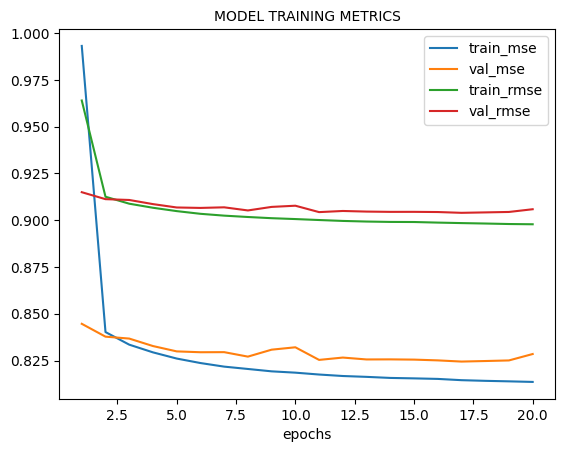

In [27]:
epochs = np.arange(1, N_EPOCHS + 1)
plt.plot(epochs, train_mses, label="train_mse")
plt.plot(epochs, val_mses, label="val_mse")

plt.plot(epochs, train_rmses, label="train_rmse")
plt.plot(epochs, val_rmses, label="val_rmse")

plt.title("MODEL TRAINING METRICS", color="k", fontsize=10)
plt.legend()
plt.xlabel("epochs", fontsize=10)
plt.show()

Next we are going to load the best model.

In [30]:
model.load_state_dict(torch.load(MODEL_NAME))

<All keys matched successfully>

Next we are going to make predict the `rating` in which the user that has an id of `3704` will rate the movie that has an id `1196`.

In [31]:
def preprocess(user:int, movie:int):
  user = torch.tensor(label_user.transform([user]), dtype=torch.long)
  movie = torch.tensor(label_movie.transform([movie]), dtype=torch.long)
  return user, movie

Next we will create a `predict_rating` function which will predict the user ratting on the specific movie.

In [32]:
def predict_rating(model, device, user:int, movie:int):
  m, u = movie, user
  user, movie = preprocess(user, movie)
  model = model.eval()
  with torch.no_grad():
    predictions = model(user.to(device), movie.to(device)).squeeze(0)
    rating = predictions.item()
  return {
      'movie': m,
      'user': u,
      'rating': float(rating)
  }
predict_rating(model, device, 3704, 1196 )

{'movie': 1196, 'user': 3704, 'rating': 4.831114768981934}